Saving glaciers_json (1).json to glaciers_json (1) (5).json
Saving annual_json (2).json to annual_json (2) (5).json
Saving co2-annmean-mlo_json (2).json to co2-annmean-mlo_json (2) (5).json
Saving epa-sea-level_json (1).json to epa-sea-level_json (1) (5).json
Coeficientes: [25.93296342  6.07148592 -1.51260394]
Intercepto: 283.8691674132636
Ecuación: y = 283.87 + 25.93*Temp + 6.07*NivelMar + -1.51*MasaGlaciar
R² entrenamiento: 0.98
R² test: -5.61
MSE (train): 9.00 | MSE (test): 43.23


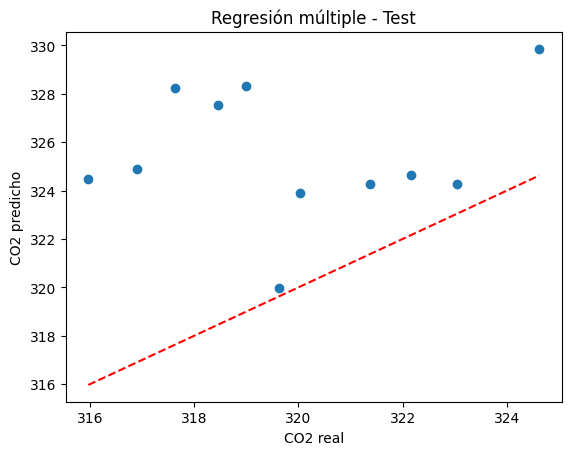

In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from google.colab import files
uploaded = files.upload()

# Temperatura
with open('annual_json (2).json', 'r') as f:
    temp_data = json.load(f)
temp_gcag = [entry for entry in temp_data if entry['Source'] == 'GCAG']
years_temp = [int(entry['Year']) for entry in temp_gcag]
temps = [entry['Mean'] for entry in temp_gcag]
df_temp = pd.DataFrame({'Year': years_temp, 'Temp': temps})

# Nivel del mar
with open('epa-sea-level_json (1).json', 'r') as f:
    sea_data = json.load(f)
years_sea = [int(entry['Year'].split('-')[0]) for entry in sea_data]
nivel_mar = [entry.get('CSIRO Adjusted Sea Level', np.nan) for entry in sea_data]
df_sea = pd.DataFrame({'Year': years_sea, 'NivelMar': nivel_mar})

# Masa glaciar
with open('glaciers_json (1).json', 'r') as f:
    glac_data = json.load(f)
years_glac = [int(entry['Year']) for entry in glac_data]
masa_glaciar = [entry.get('Mean cumulative mass balance', np.nan) for entry in glac_data]
df_glac = pd.DataFrame({'Year': years_glac, 'MasaGlaciar': masa_glaciar})

# CO2
with open('co2-annmean-mlo_json (2).json', 'r') as f:
    co2_data = json.load(f)
years_co2 = [int(entry['Year'].split('-')[0]) for entry in co2_data]
co2s = [entry['Mean'] for entry in co2_data]
df_co2 = pd.DataFrame({'Year': years_co2, 'CO2': co2s})

# Unir DataFrames solo en años comunes
df = df_temp.merge(df_sea, on='Year').merge(df_glac, on='Year').merge(df_co2, on='Year')

# Eliminar cualquier fila con valores NaN (muy importante para sklearn)
df = df.dropna()

# X e y
X = df[['Temp', 'NivelMar', 'MasaGlaciar']].values
y = df['CO2'].values

# División train/test 80/20
split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)
print(f"Ecuación: y = {modelo.intercept_:.2f} + {modelo.coef_[0]:.2f}*Temp + {modelo.coef_[1]:.2f}*NivelMar + {modelo.coef_[2]:.2f}*MasaGlaciar")
print(f"R² entrenamiento: {r2_score(y_train, y_pred_train):.2f}")
print(f"R² test: {r2_score(y_test, y_pred_test):.2f}")
print(f"MSE (train): {mean_squared_error(y_train, y_pred_train):.2f} | MSE (test): {mean_squared_error(y_test, y_pred_test):.2f}")

# Gráfica comparación test
plt.scatter(y_test, y_pred_test)
plt.xlabel("CO2 real")
plt.ylabel("CO2 predicho")
plt.title("Regresión múltiple - Test")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

